# Experiments for a Large Square Lattice

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

from collections import OrderedDict
import logging
import math

from matplotlib import pyplot as plt
import networkx as nx
import numpy as np

import torch
from torchdiffeq import odeint, odeint_adjoint

sys.path.append('../../')
sys.path.append('../kuramoto_utilities/')

# Baseline imports
from gd_controller import AdjointGD
from dynamics import ForwardKuramotoDynamics, BackwardKuramotoDynamics

# Various Utilities
from utilities import evaluate, calculate_critical_coupling_constant, comparison_plot, state_plot
from nnc.helpers.torch_utils.oscillators import order_parameter_cos
from nn import TrainingAlgorithm, EluTimeControl
logging.getLogger().setLevel(logging.CRITICAL) # set to info to look at loss values etc.

## Load graph parameters
Basic setup for calculations, graph, number of nodes, etc.

In [2]:
dtype = torch.float32
graph_type = 'square_lattice_large'
side_size = 32
dtype = torch.float32
device = 'cpu'

result_folder = '../../results/' + graph_type + os.path.sep

G = nx.grid_graph([side_size, side_size],  periodic=False)
G = nx.relabel_nodes(G, lambda x: x[0]*side_size + x[1])

n_nodes = nx.number_of_nodes(G)
adjacency_matrix = np.array(nx.adjacency_matrix(G).todense())
adjacency_matrix = torch.tensor(adjacency_matrix, dtype=dtype, device=device)



driver_vector = torch.ones([adjacency_matrix.shape[0],1], device=device)

result_folder = '../../results/' + graph_type + os.path.sep
os.makedirs(result_folder, exist_ok=True)

## Load dynamics parameters
Load natural frequencies and initial states which are common for all graphs and also calculate the coupling constant which is different per graph. We use a coupling constant value that is $1%$ of the critical coupling constant value.

In [3]:
total_time = 10
torch.manual_seed(2)
# initial angle
theta_0 = torch.empty([1, n_nodes], device=device)#.normal_(mean=0, std=0.8)
theta_0[:, :512] = torch.empty([1,512], device=device).normal_(mean=np.pi/4, std=0.5)
theta_0[:, 512:] = torch.empty([1,512], device=device).normal_(mean=-np.pi/4, std=0.5)

# omega
natural_frequencies = torch.empty([n_nodes], device=device).normal_(mean=0, std=0.2)
critical_coupling_constant = calculate_critical_coupling_constant(adjacency_matrix.cpu(), natural_frequencies.cpu())\
    .to(device)
coupling_constant = 0.01*critical_coupling_constant

## Initialize Dynamics
Here we initialize the Kuramoto dynamics, both forward and backward (adjoint system). The backward system is used for the control baseline of the ajoint gradient, whereas the forward dynamics are used for both control models.

In [4]:
forward_dynamics = ForwardKuramotoDynamics(adjacency_matrix, 
                                           driver_vector, 
                                           coupling_constant, 
                                           natural_frequencies, 
                                           device=device
                                          )
backward_dynamics = BackwardKuramotoDynamics(adjacency_matrix, 
                                             driver_vector, 
                                             coupling_constant, 
                                             natural_frequencies,
                                             device=device
                                            )

## No Control
Here we run the dynamics without control to determine the evolution of $r(t)$ and the states when no control is applied. Since the control is multiplicative, no control tranlsates to using $u(t) = 1, \forall t$.

In [5]:
?forward_dynamics.forward

In [6]:
no_controls = []
def no_control(x):
    return 1

from torchdiffeq import odeint


no_control = lambda y,t: torch.tensor([[1]], device=device).float()
no_control_dyns = lambda t,y: forward_dynamics(t,y,u=no_control(t,y))
no_control_states = odeint(no_control_dyns, y0=theta_0, t=torch.linspace(0, total_time, 100)).squeeze().cpu().numpy()


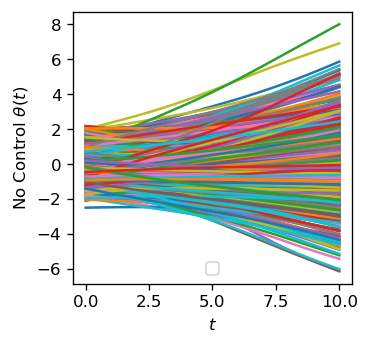

In [7]:
fig = state_plot(no_control_states, np.linspace(0, total_time, no_control_states.shape[0]), "No Control $\\theta (t)$")
fig.savefig(result_folder + 'no_control_states.pdf')

## NODEC
We now train NODEC with a shallow neural network. We initialize the parameters in a deterministic manner, and use stochastic gradient descent to train it. The learning rate, number of epochs and neural architecture may change per graph.

In [8]:
tg1 = np.pi/4#torch.empty([1,512], device=device).normal_(mean=np.pi/4, std=0.1)
tg2 = -np.pi/4#torch.empty([1,512], device=device).normal_(mean=-np.pi/4, std=0.1)

def calculate_loss(A, x):
    #loss = (x**2-np.pi/4**2)**2
    loss = ((x[:, :512]-tg1)**2).mean() + ((x[:, 512:]-tg2)**2).mean()
    return loss
logging.basicConfig(level=logging.INFO)


In [9]:
?torch.Tensor.normal_

Docstring:
normal_(mean=0, std=1, *, generator=None) -> Tensor

Fills :attr:`self` tensor with elements samples from the normal distribution
parameterized by :attr:`mean` and :attr:`std`.
Type:      method_descriptor


In [9]:
import plotly.express as px
x = torch.zeros([1024])
x[:512] = 1


In [10]:
class NNControl(torch.nn.Module):
    """
    Very simple Elu architecture for control of linear systems
    """

    def __init__(self, hidden_layer_sizes=(15,), n_drivers = 1):
        super().__init__()

        total_sizes = [1] + hidden_layer_sizes + [n_drivers]
        module_list = []
        for i in range(len(total_sizes) - 1):
            module_list.append(torch.nn.Linear(total_sizes[i],
                                               total_sizes[i + 1]))
        self.layers = torch.nn.ModuleList(module_list)

    def forward(self, t, x):
        """
        :param t: A scalar or a batch with scalars
        :param x: input_states for all nodes
        :return:
        """
        t = t.detach()
        # check for batch sizes and if t is scalar:
        if len(t.shape) in {0, 1}:
            if x is not None and len(list(x.shape)) > 1:
                t = t.repeat(x.shape[0], 1)
            else:
                t = t.unsqueeze(0)
        u = self.layers[0](t)
        for i in range(1, len(self.layers) - 1):
            u = self.layers[i](u)
            #if i < len(self.layers) - 1:
            u = torch.nn.functional.elu(u)

        u = self.layers[-1](u)
        return u



In [11]:
theta_0.min()

tensor(-2.4757)

In [18]:
neural_net2 = EluTimeControl([16]).to(device)

for parameter in neural_net2.parameters():
    parameter.data = torch.ones_like(parameter.data)/1000 # deterministic init!
train_algo = TrainingAlgorithm(neural_net2, forward_dynamics)
best_model2 = train_algo.train(theta_0, total_time, epochs=4, lr=0.12, allow_logging=True)
#best_model2 = train_algo.train(theta_0, total_time, epochs=1, lr=0.001, allow_logging=True)


INFO:root:Training epoch: 0
INFO:root:Current loss is: 2027.9754638671875
INFO:root:Training epoch: 1
INFO:root:Current loss is: 1330.301025390625
INFO:root:Training epoch: 2
INFO:root:Current loss is: 0.007054808549582958
INFO:root:Training epoch: 3
INFO:root:Current loss is: 0.007054646033793688


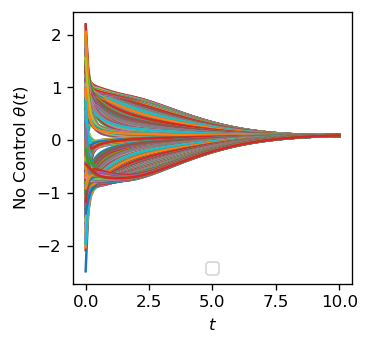

In [19]:

nn2_dyns = lambda t,y: forward_dynamics(t,y,u=best_model2(t,y))
nn_states2 = odeint(nn2_dyns, y0=theta_0, t=torch.linspace(0, total_time, 100))\
    .squeeze().cpu().detach().numpy()

fig = state_plot(nn_states2, np.linspace(0, total_time, nn_states2.shape[0]), "No Control $\\theta (t)$")

In [20]:
neural_net = EluTimeControl([16]).to(device)
for parameter in neural_net.parameters():
    parameter.data =torch.ones_like(parameter.data)/1000 #parameter.data/100#torch.ones_like(parameter.data)/1000 # deterministic init!

In [21]:
logging.getLogger().setLevel(logging.INFO) # set to info to look at loss values etc.
train_algo = TrainingAlgorithm(neural_net, forward_dynamics)
best_model = train_algo.train(theta_0, total_time, epochs=280, lr=15, calculate_loss=calculate_loss, allow_logging=True)

INFO:root:Training epoch: 0
INFO:root:Current loss is: 8.73292350769043
INFO:root:Training epoch: 1
INFO:root:Current loss is: 0.27617937326431274
INFO:root:Training epoch: 2
INFO:root:Current loss is: 0.2750561237335205
INFO:root:Training epoch: 3
INFO:root:Current loss is: 0.27424314618110657
INFO:root:Training epoch: 4
INFO:root:Current loss is: 0.2736349105834961
INFO:root:Training epoch: 5
INFO:root:Current loss is: 0.27316606044769287
INFO:root:Training epoch: 6
INFO:root:Current loss is: 0.2727947533130646
INFO:root:Training epoch: 7
INFO:root:Current loss is: 0.2724931836128235
INFO:root:Training epoch: 8
INFO:root:Current loss is: 0.2722424268722534
INFO:root:Training epoch: 9
INFO:root:Current loss is: 0.27202898263931274
INFO:root:Training epoch: 10
INFO:root:Current loss is: 0.271843284368515
INFO:root:Training epoch: 11
INFO:root:Current loss is: 0.27167809009552
INFO:root:Training epoch: 12
INFO:root:Current loss is: 0.2715279459953308
INFO:root:Training epoch: 13
INFO:ro

INFO:root:Training epoch: 109
INFO:root:Current loss is: 0.2650596797466278
INFO:root:Training epoch: 110
INFO:root:Current loss is: 0.2649809420108795
INFO:root:Training epoch: 111
INFO:root:Current loss is: 0.26490023732185364
INFO:root:Training epoch: 112
INFO:root:Current loss is: 0.2648175358772278
INFO:root:Training epoch: 113
INFO:root:Current loss is: 0.2647327780723572
INFO:root:Training epoch: 114
INFO:root:Current loss is: 0.2646459639072418
INFO:root:Training epoch: 115
INFO:root:Current loss is: 0.2645569443702698
INFO:root:Training epoch: 116
INFO:root:Current loss is: 0.2644656300544739
INFO:root:Training epoch: 117
INFO:root:Current loss is: 0.2643721103668213
INFO:root:Training epoch: 118
INFO:root:Current loss is: 0.2642762064933777
INFO:root:Training epoch: 119
INFO:root:Current loss is: 0.2641778588294983
INFO:root:Training epoch: 120
INFO:root:Current loss is: 0.26407697796821594
INFO:root:Training epoch: 121
INFO:root:Current loss is: 0.26397356390953064
INFO:root

INFO:root:Current loss is: 0.2666313648223877
INFO:root:Training epoch: 217
INFO:root:Current loss is: 0.26660865545272827
INFO:root:Training epoch: 218
INFO:root:Current loss is: 0.2665867805480957
INFO:root:Training epoch: 219
INFO:root:Current loss is: 0.2665649652481079
INFO:root:Training epoch: 220
INFO:root:Current loss is: 0.2665431499481201
INFO:root:Training epoch: 221
INFO:root:Current loss is: 0.2665213346481323
INFO:root:Training epoch: 222
INFO:root:Current loss is: 0.26649951934814453
INFO:root:Training epoch: 223
INFO:root:Current loss is: 0.2664777338504791
INFO:root:Training epoch: 224
INFO:root:Current loss is: 0.2664559781551361
INFO:root:Training epoch: 225
INFO:root:Current loss is: 0.2664342224597931
INFO:root:Training epoch: 226
INFO:root:Current loss is: 0.26641249656677246
INFO:root:Training epoch: 227
INFO:root:Current loss is: 0.26639077067375183
INFO:root:Training epoch: 228
INFO:root:Current loss is: 0.2663690447807312
INFO:root:Training epoch: 229
INFO:roo

### NODEC Evaluation
we evalaute NODEC by using the same methodology we used for ADG control.

In [22]:

nn_dyns = lambda t,y: forward_dynamics(t,y,u=best_model(t,y))
nn_states = odeint(nn_dyns, y0=theta_0, t=torch.linspace(0, total_time, 100))\
    .squeeze().cpu().detach().numpy()

In [23]:
calculate_loss(None, no_control_states[-1:])/calculate_loss(None, nn_states[-1:])

23.960037

## Comparison and Evaluation
We compare order parameter, energy and state evolution for the control methods.
The plots below show individual states and energy/order parameter comparisons between ADG and NODEC.

In [24]:
alltheta = np.concatenate([nn_states2[-1], nn_states[-1], no_control_states[-1]])
vmin = -np.pi#alltheta.min()
vmax = np.pi#alltheta.max()
logging.getLogger().setLevel(logging.CRITICAL) # set to info to look at loss values etc.

In [25]:
vmax

3.141592653589793

## Time Evaluation

/home/lucasb/anaconda3/envs/TCR/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning:

Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.

/home/lucasb/anaconda3/envs/TCR/lib/python3.6/site-packages/ipykernel_launcher.py:143: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



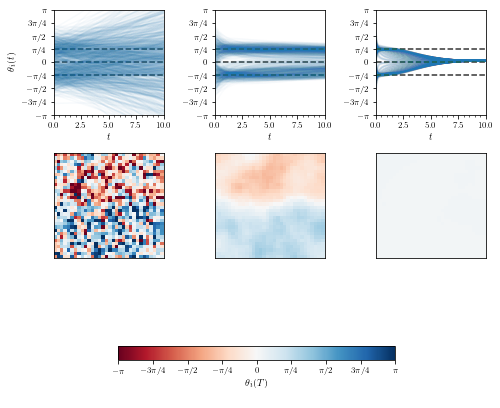

In [33]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
                               
# customized settings
params = {  # 'backend': 'ps',
    'font.family': 'serif',
    'font.serif': 'Latin Modern Roman',
    'font.size': 10,
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'savefig.dpi': 150,
    'text.usetex': True,
    'text.latex.preamble': [r"\usepackage{bm}", r"\usepackage{mathtools}"]}
    # tell matplotlib about your params

rcParams.update(params)
# set nice figure sizes
fig_width_pt = 510    # Get this from LaTeX using \showthe\columnwidth
golden_mean = (np.sqrt(5.) - 1.) / 2.  # Aesthetic ratio
ratio = golden_mean
inches_per_pt = 1. / 72.27  # Convert pt to inches
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width*(ratio+0.2)# height in inches
fig_size = [fig_width, fig_height]
rcParams.update({'figure.figsize': fig_size})

xx = np.linspace(0,total_time,no_control_states.shape[0])


fig, ax = plt.subplots(ncols=3, nrows=3)
#ax[0,0].text(0.02*10,0.89*2*np.pi-np.pi,r"(a)")
# ax[0,1].text(0.02*10,0.89*2*np.pi-np.pi,r"(b)")
# ax[0,2].text(0.02*10,0.89*2*np.pi-np.pi,r"(c)")
# props = dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.8,edgecolor="white")
# ax[1,0].text(0.03*32,0.89*32,r"(d)",bbox=props)
# ax[1,1].text(0.03*32,0.89*32,r"(e)",bbox=props)
# ax[1,2].text(0.03*32,0.89*32,r"(f)",bbox=props)
ax[0,0].plot(xx,np.pi/4*np.ones_like(xx),ls="--",color="k",alpha=0.8)
ax[0,0].plot(xx,-np.pi/4*np.ones_like(xx),ls="--",color="k",alpha=0.8)
ax[0,0].plot(xx,np.zeros_like(xx),ls="--",color="k",alpha=0.8)
ax[0,1].plot(xx,np.pi/4*np.ones_like(xx),ls="--",color="k",alpha=0.8)
ax[0,1].plot(xx,-np.pi/4*np.ones_like(xx),ls="--",color="k",alpha=0.8)
ax[0,1].plot(xx,np.zeros_like(xx),ls="--",color="k",alpha=0.8)
ax[0,2].plot(xx,np.pi/4*np.ones_like(xx),ls="--",color="k",alpha=0.8)
ax[0,2].plot(xx,-np.pi/4*np.ones_like(xx),ls="--",color="k",alpha=0.8)
ax[0,2].plot(xx,np.zeros_like(xx),ls="--",color="k",alpha=0.8)
ax[0,0].plot(xx,no_control_states,color="tab:blue",alpha=0.03)
ax[0,1].plot(xx,nn_states,color="tab:blue",alpha=0.02)
ax[0,2].plot(xx,nn_states2,color="tab:blue",alpha=0.01)


import matplotlib.colors as colors

# bounds = np.linspace(-np.pi, np.pi, 18)
# norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
norm = None
c = ax[1,1].pcolormesh(nn_states[-1].reshape(32,32), 
                   cmap='RdBu', vmin=vmin, vmax=vmax,norm=norm)
ax[1,1].set_xticks([]) 
ax[1,1].set_yticks([]) 
# cbar = fig.colorbar(c, ax=ax[1,1])
# cbar.ax.set_ylabel(r'$\theta(T)$', rotation=90)



c1 = ax[1,2].pcolormesh(nn_states2[-1].reshape(32,32), 
                   cmap='RdBu', vmin=vmin, vmax=vmax,
                        norm=norm)
ax[1,2].set_xticks([]) 
ax[1,2].set_yticks([]) 



cbar = fig.colorbar(c1, ax=ax[2,:], orientation="horizontal")
cbar.ax.set_xlabel(r'$\theta_i(T)$', 
                   rotation=0
                  )
cbar.set_ticks([-np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4, 0, 
                    np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
cbar.set_ticklabels([r"$-\pi$",r"$-3\pi/4$",r"$-\pi/2$",r"$-\pi/4$",
                         r"$0$",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
cbar.set_xlim = (-np.pi, np.pi)

c2 = ax[1,0].pcolormesh(no_control_states[-1].reshape(32,32), 
                   cmap='RdBu', vmin=vmin, vmax=vmax,norm=norm)
ax[1,0].set_xticks([]) 
ax[1,0].set_yticks([]) 
ax[2, 0].axis('off')
ax[2, 1].axis('off')
ax[2, 2].axis('off')

# cbar = fig.colorbar(c2, ax=ax[1,0])
# cbar.ax.set_ylabel(r'$\theta(T)$', rotation=90)


ax[0,0].set_xlim(0,total_time)
ax[0,1].set_xlim(0,total_time)
ax[0,2].set_xlim(0,total_time)

ax[0,0].xaxis.set_minor_locator(MultipleLocator(0.5))
ax[0,1].xaxis.set_minor_locator(MultipleLocator(0.5))
ax[0,2].xaxis.set_minor_locator(MultipleLocator(0.5))

ax[0,0].set_xticks(np.linspace(0,total_time,5))
ax[0,1].set_xticks(np.linspace(0,total_time,5))
ax[0,2].set_xticks(np.linspace(0,total_time,5))

ax[0,0].set_ylim(-np.pi,np.pi)
ax[0,0].set_yticks([-np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4, 0, 
                    np.pi/4, np.pi/2, 3*np.pi/4, np.pi])#[-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
ax[0,0].set_yticklabels([r"$-\pi$",r"$-3\pi/4$",r"$-\pi/2$",r"$-\pi/4$",
                         r"$0$",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])#[r"$-\pi/2$",r"$-\pi/4$",r"$0$",r"$\pi/4$",r"$\pi/2$"])

ax[0,1].set_ylim(-np.pi,np.pi)
ax[0,1].set_yticks([-np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])#[-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
ax[0,1].set_yticklabels([r"$-\pi$",r"$-3\pi/4$",r"$-\pi/2$",r"$-\pi/4$",
                         r"$0$",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
#ax[0,2].set_ylim(-3*np.pi/4,3*np.pi/4)
ax[0,2].set_ylim(-np.pi,np.pi)
ax[0,2].set_yticks([-np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4,
                    0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])#[-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
ax[0,2].set_yticklabels([r"$-\pi$",r"$-3\pi/4$",r"$-\pi/2$",r"$-\pi/4$",
                         r"$0$",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
#ax[0,2].set_yticks([-3*np.pi/4,-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2,3*np.pi/4])
#ax[0,2].set_yticklabels([r"$-3\pi/4$",r"$-\pi/2$",r"$-\pi/4$",r"$0$",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$"])

ax[0,0].set_xlabel(r"$t$")
ax[0,1].set_xlabel(r"$t$")
ax[0,2].set_xlabel(r"$t$")
ax[0,0].set_ylabel(r"$\theta_i(t)$")
ax[0,0].set_rasterized(True)
ax[0,1].set_rasterized(True)
ax[0,2].set_rasterized(True)
#ax[1,0].set_rasterized(True)
#ax[1,1].set_rasterized(True)
#ax[1,2].set_rasterized(True)
plt.rcParams['savefig.facecolor']='white'
plt.tight_layout()
plt.savefig("kuramoto_two_states.pdf",dpi=480)
plt.show()